### Interpreting the Orders Dataset

For questions 1, 2, and 3, I will work with sales data from a marketplace with several stores. The attached CSV, `orders_v202102.csv`, lists the customer, date, and dollar value of orders placed in 2017. The gender of each customer is also provided. Not excluding $0 orders

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Exercise 1

Assemble a dataframe with one row per customer and the following columns:
* customer_id 
* gender
* most_recent_order_date 
* order_count (number of orders placed by this customer)

Sort the dataframe by customer_id ascending and display the first 10 rows.

First, I read the orders CSV file into a dataframe, and make sure that the date variable is read in as a datetime object. Then, to get an understanding of the contents of the data, I display the first few observations and the types of each variable. 

In [ ]:
# import CSV
orders = pd.read_csv('/orders_v202102.csv', parse_dates=['date'])
orders.head()

,customer_id,gender,date,value
0,1000,0,2017-01-01 00:11:31,198.5
1,1001,0,2017-01-01 00:29:56,338.0
2,1002,1,2017-01-01 01:30:31,733.0
3,1003,1,2017-01-01 01:34:22,772.0
4,1004,0,2017-01-01 03:11:54,508.0


In [ ]:
orders.dtypes

customer_id             int64
gender                  int64
date           datetime64[ns]
value                 float64
dtype: object

Next, I want to create a new dataframe with customer_id, gender, most_recent_order_date, and order_count. The last two columns will be calculated through aggregations: getting the max date and count for each customer_id. Since groupby preserves the order within each group, the resulting dataframe is already sorted by customer_id ascending. 

In [ ]:
orders_new = orders.groupby(['customer_id', 'gender']).agg(most_recent_order=('date', 'max'), order_count=('customer_id', 'count')).reset_index()
orders_new.head(10)

,customer_id,gender,most_recent_order,order_count
0,1000,0,2017-01-01 00:11:31,1
1,1001,0,2017-01-01 00:29:56,1
2,1002,1,2017-02-19 21:35:31,3
3,1003,1,2017-04-26 02:37:20,4
4,1004,0,2017-01-01 03:11:54,1
5,1005,1,2017-12-16 01:39:27,2
6,1006,1,2017-05-09 15:27:20,3
7,1007,0,2017-01-01 15:59:50,1
8,1008,0,2017-12-17 05:47:48,3
9,1009,1,2017-01-01 19:27:17,1


### Exercise 2
Plot the count of orders per week (for all stores together). Do not use plotly, as plotly graphs in Jupyter Notebooks don't render correctly on different machines.

First, I want to see the range of dates in the orders data. This will give me an idea of how I want to plot per week. 

In [ ]:
print('Earliest date: ', min(orders['date']))
print('Latest date: ', max(orders['date']))

Earliest date:  2017-01-01 00:11:31
Latest date:  2017-12-31 23:35:09


Since the order dates range from the first day of 2017 to the last day of 2017, I want to plot each week of 2017 as Week 00 to Week 52. 

In [ ]:
orders['week_number'] = orders['date'].dt.strftime('Week %W')
orders.head()

,customer_id,gender,date,value,week_number
0,1000,0,2017-01-01 00:11:31,198.5,Week 00
1,1001,0,2017-01-01 00:29:56,338.0,Week 00
2,1002,1,2017-01-01 01:30:31,733.0,Week 00
3,1003,1,2017-01-01 01:34:22,772.0,Week 00
4,1004,0,2017-01-01 03:11:54,508.0,Week 00


Next, I group by the week number and aggregate the total order counts per week.

In [ ]:
orders_per_week = orders.groupby(['week_number']).agg(total_order_count = ('customer_id', 'count')).reset_index()
orders_per_week.head()

,week_number,total_order_count
0,Week 00,14
1,Week 01,180
2,Week 02,264
3,Week 03,405
4,Week 04,233


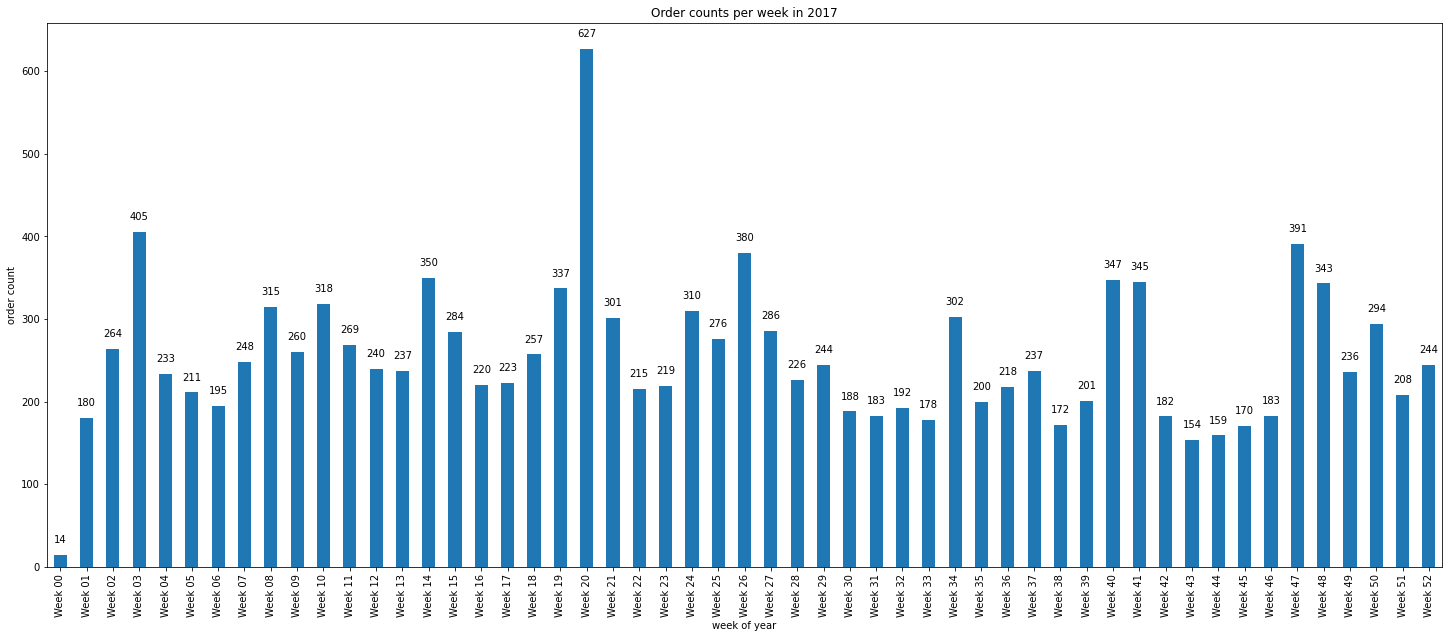

In [ ]:
# plot order count by week 
ax = orders_per_week.plot.bar(x='week_number', y='total_order_count', figsize=(25,10), legend=None)
ax.set_xlabel('week of year')
ax.set_ylabel('order count')
ax.set_title('Order counts per week in 2017')

for b in ax.patches:

    x_value = b.get_x() + b.get_width() / 2
    y_value = b.get_height()
    label = b.get_height()

    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0,15),          
        textcoords="offset points", 
        va='center',
        ha='center') 

plt.show()

Week 21 seems to have the largest number of order counts at 627 orders, while Week 00 has the fewest order count at 14 orders. 

### Exercise 3

Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? 

**Justify your choice of method and state any assumptions you make. Make sure you are clear about why your method is suitable for this dataset, in particular.**.

Starting with a simple aggregation below, I see that gender 0 has a higher average order value than gender 1. However, in order to determine if this difference is statistically significant, I must do further analysis. 

In [ ]:
orders.groupby(['gender']).agg(mean_order_value = ('value', 'mean'))

,mean_order_value
gender,
0,363.890006
1,350.708361


Since I am comparing the means for two groups (gender 0 and gender 1), the best method to use is an independent two sample t-test. We consider the following hypotheses:



> Null hypothesis: The mean order value for gender 0 and gender 1 is the same. 


> Alternative hypothesis: The mean order value for gender 0 and gender 1 is different, thus statistically significant.





It is important to check the assumptions of a t-test. First, I want to see the sample size and distribution of the data. 

In [ ]:
orders['gender'].value_counts()

0    6759
1    6712
Name: gender, dtype: int64

There are more customers with gender 0 than there are customers with gender 1, but the difference is not very large compared to the large size of the data. Next, I will check for a normal distribution. 

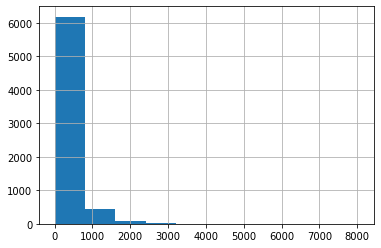

In [ ]:
orders[orders['gender'] == 0]['value'].hist()

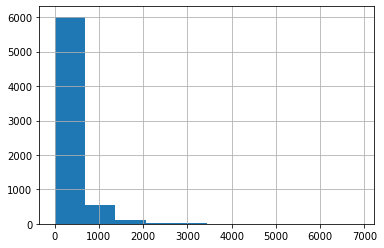

In [ ]:
orders[orders['gender'] == 1]['value'].hist()

Both gender 0 and gender 1 have skewed distributions, but since the sample size is quite large, I will not be too concerned about a normality violation. I will proceed with a t-test. I also want to check for equal variances with a Levene test of Equal Variances, which tests the null hypothesis that samples have equal variances against the threshold of 0.05. 

In [ ]:
stats.levene(orders[orders['gender'] == 0]['value'], orders[orders['gender'] == 1]['value'])

LeveneResult(statistic=5.523015358033226, pvalue=0.018782230716425024)

Since the p-value < 0.05, I reject the null and move forward with unequal variances. 

In [ ]:
stats.ttest_ind(orders[orders['gender'] == 0]['value'], orders[orders['gender'] == 1]['value'], equal_var = False)

Ttest_indResult(statistic=1.976107933576866, pvalue=0.04816296295128402)

From the results of the t-test, I see that the p-value = 0.048, which is less than the 0.05 threshold. Therefore, the difference in mean order value between gender 0 and 1 seems to be statistically significant. In other words, there appears to be evidence to conclude the average order value for gender 0 and gender 1 is not the same. 

### Interpreting the Product Dataset
For this question I will work with the data in the CSV `products_v202102.csv`. This dataset shows the number of times a particular item was sold. It contains the following columns: 
* number_of_orders - the number of orders containing the product
* store_id - the ID of the store selling the product
* product_id - the ID of the product itself
* is_red - whether the product is red.

### Exercise 4

Suppose some of our customers came to us with the belief that the color red generates more sales than other colors.  Based on this dataset, would you suggest that companies color more of their products red? Why or why not, and what other factors could be important to determine this? 

**Please justify your answer and state any assumptions you make.**

First, I will import the dataset and display the first few observations. 

In [ ]:
products = pd.read_csv('/products_v202102.csv')
products.head()

,store_id,product_id,is_red,number_of_orders
0,0,0,True,15
1,0,100,True,37
2,0,200,True,36
3,0,300,False,11
4,0,400,False,10


Since the is_red column is expressed as True/False, I convert to binary. 

In [ ]:
products['is_red'] = (products['is_red'] == True).astype(int)
products.head()

,store_id,product_id,is_red,number_of_orders
0,0,0,1,15
1,0,100,1,37
2,0,200,1,36
3,0,300,0,11
4,0,400,0,10


I want to do some initial exploring to see the distributions of red vs non-red products. As seen below, there are more red products than non-red. The average number of red products sold is higher than that of non-red products. 

In [ ]:
products['is_red'].value_counts()

1    1544
0    1456
Name: is_red, dtype: int64

In [ ]:
print('Average number of red products sold: ', int(products[products['is_red'] == 1]['number_of_orders'].mean()))
print('Average number of non-red products sold: ', int(products[products['is_red'] == 0]['number_of_orders'].mean()))

Average number of red products sold:  26
Average number of non-red products sold:  23


To see if a product being red has an effect on sales, I want to perform a one-way ANOVA test. I want to check for normality and equal variances. 

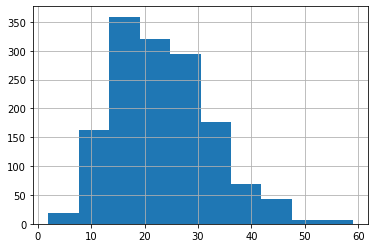

In [ ]:
products[products['is_red'] == 0]['number_of_orders'].hist()

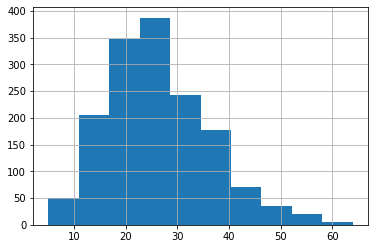

In [ ]:
products[products['is_red'] == 1]['number_of_orders'].hist()

Both is_red = 0 and is_red = 1 has pretty normal distributions, so I use the Levene Test of Equal variances again to see how I should proceed. 

In [ ]:
stats.levene(products[products['is_red'] == 0]['number_of_orders'], products[products['is_red'] == 1]['number_of_orders'])

LeveneResult(statistic=11.70247228817246, pvalue=0.000632521642954754)

Since I have a pvale < 0.05, I know there are unequal variances, but since ANOVA can be robust to unequal variances, I will still proceed. 

In [ ]:
stats.f_oneway(products[products['is_red'] == 0]['number_of_orders'], products[products['is_red'] == 1]['number_of_orders'])

F_onewayResult(statistic=63.981255782212685, pvalue=1.777247322763986e-15)

The result of the ANOVA is a very small pvalue < 0.05, so I reject the null hypothesis and conclude that red products do have some significant effect on sales. I would suggest that companies color more of their products red. It is also important to determine other factors of red products that might affect sales, other than the color. There may be more frequently sold product types that are red that should be identified to increase sales.  

### Exercise 5

Describe one of your favorite tools or techniques and give a small example of how it has helped you solve a problem. Limit your answer to one short paragraph, and please be specific. 

My favorite tool for solving data analysis problems is Juptyer notebooks. I recently completed a healthcare predictive analysis project in which I wanted to analyze demographics data and predict if a person had healthcare insurance or not. I used Jupyter notebooks to apply data science techniques like exploratory data analysis and modeling with Python. This is a great tool to use in the data science field because it gives the user the ability to test and see the output of code in snippets, which allows for a smooth process. For this project, I was able to practice machine learning concepts in Jupyter notebooks and create a shareable report with visualizations of my findings. 